## To do
Analysis issues:
1. Use finer location data for taxi trips.
2. Map the origins and destinations for these trips. Heat maps?
3. Run regression model to predict bad traffic days.

Technical issues:

# Summary
This notebook is a continuation of the chicago-taxi and chicago-taxi_full_1 notebooks. This notebook focuses on doing finer location analysis.

We take rides that start from 8:00 to 10:45 as AM peak, from 16:00 to 20:45 as PM peak (I may choose to narrow these down later). In the chicago-taxi_make_smaller_JSON notebook, I saved the relevant pieces of the original database to 4 smaller JSON files (~1GB each).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import date
from sklearn import linear_model, preprocessing
import geopandas as gpd
from shapely.geometry import Point
from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
#import the morning taxi rides to and from the loop
df_am_from_loop = pd.read_json('Data/am_from_loop.json')
df_am_to_loop = pd.read_json('Data/am_to_loop.json')

In [3]:
df_am_from_loop.head()

,Dropoff Census Tract,Pickup Census Tract,end_time,fare,start_time
100000028,17031081403,17031320100,2016-08-02 11:00:00,5.50,2016-08-02 10:45:00
100000029,17031081201,17031320100,2015-08-08 10:15:00,6.45,2015-08-08 10:00:00
100000032,17031320100,17031839100,2014-04-14 09:30:00,5.45,2014-04-14 09:15:00
100000046,17031081300,17031320600,2013-07-25 08:30:00,7.65,2013-07-25 08:30:00
100000065,17031839100,17031839100,2016-03-17 09:30:00,5.00,2016-03-17 09:15:00


In [4]:
df_am_to_loop.head()

,Dropoff Census Tract,Pickup Census Tract,end_time,fare,start_time
100000032,17031320100,17031839100,2014-04-14 09:30:00,5.45,2014-04-14 09:15:00
100000065,17031839100,17031839100,2016-03-17 09:30:00,5.00,2016-03-17 09:15:00
100000198,17031839100,17031281900,2014-05-23 09:00:00,4.84,2014-05-23 08:45:00
100000205,17031839100,17031081800,2016-07-21 10:15:00,7.75,2016-07-21 10:15:00
100000215,17031839100,17031980100,2015-10-10 09:15:00,26.25,2015-10-10 09:00:00


In [5]:
df_am_from_loop.memory_usage(deep=True)

Index                   19747696
Dropoff Census Tract    19747696
Pickup Census Tract     19747696
end_time                19747696
fare                    19747696
start_time              19747696
dtype: int64

In [6]:
df_am_from_loop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2468462 entries, 100000028 to 99999998
Data columns (total 5 columns):
Dropoff Census Tract    int64
Pickup Census Tract     int64
end_time                datetime64[ns]
fare                    float64
start_time              datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2)
memory usage: 113.0 MB


In [9]:
#distinguish weekdays and weekends (I could also do holidays if that's something I need to consider)
df_am_from_loop['weekday'] = df_am_from_loop['start_time'].apply(lambda x: int(date.weekday(x) < 5))
df_am_to_loop['weekday'] = df_am_to_loop['start_time'].apply(lambda x: int(date.weekday(x) < 5))

In [137]:
#make a list of census tracts in the Loop.
#For now, I only want to consider rides that cross over between the Loop and elsewhere
loop_tracts = [17031320100, 17031320400, 17031320600, 17031839000, 17031839100]

In [140]:
am_from_loop_pickup_count = df_am_from_loop[df_am_from_loop.weekday == 1].groupby('Pickup Census Tract').count()['weekday']
am_from_loop_dropoff_count = df_am_from_loop[df_am_from_loop.weekday == 1].groupby('Dropoff Census Tract').count()['weekday']
am_to_loop_pickup_count = df_am_to_loop[df_am_to_loop.weekday == 1].groupby('Pickup Census Tract').count()['weekday']
am_to_loop_dropoff_count = df_am_to_loop[df_am_to_loop.weekday == 1].groupby('Dropoff Census Tract').count()['weekday']

In [132]:
am_to_loop_dropoff_count

Dropoff Census Tract
17031320100     812413
17031320400     275951
17031320600      76895
17031839000      11251
17031839100    2479857
Name: weekday, dtype: int64

Unsurprisingly, the highest count occurs in census tract '17031839100', which is the northwestern end of the Loop, where many high-rise office buildings are.

It may be necessary to also look at neighboring census tracts, just outside the loop, to see how much of a dropoff there is in the taxi traffic.

In [141]:
#make maps
chi_map = gpd.read_file('Data/Boundaries - Census Tracts - 2010.geojson')
#Make geoid10 into int, and make it the index, as that's what I have in the taxi ride database
chi_map['geoid10'] = chi_map['geoid10'].astype(int)
chi_map = chi_map.set_index(chi_map.geoid10)

In [142]:
#The project at the beginning is (latitude, longitude), called 'epsg:4326' in GeoPandas.
#This projection is not good for plotting Chicago, which is so far north that
#1 degree of longitude is much shorter than 1 degree of latitude in terms of distance.
chi_map.crs

{'init': 'epsg:4326'}

In [143]:
#Try changing it to Mercator
test = chi_map['geometry']
test.to_crs({'init': 'epsg:3395'}).head()

geoid10
17031842400    (POLYGON ((-9754264.404603189 5092203.79040726...
17031840300    (POLYGON ((-9761169.775256557 5105995.45623638...
17031841100    (POLYGON ((-9754854.286588391 5110437.53401059...
17031841200    (POLYGON ((-9761398.53680929 5110868.440691042...
17031838200    (POLYGON ((-9759137.081353614 5113622.44898917...
Name: geometry, dtype: object

In [144]:
chi_map['geometry'] = chi_map.geometry.to_crs(epsg=3395)

In [145]:
chi_map['geometry'].head()

geoid10
17031842400    (POLYGON ((-9754264.404603189 5092203.79040726...
17031840300    (POLYGON ((-9761169.775256557 5105995.45623638...
17031841100    (POLYGON ((-9754854.286588391 5110437.53401059...
17031841200    (POLYGON ((-9761398.53680929 5110868.440691042...
17031838200    (POLYGON ((-9759137.081353614 5113622.44898917...
Name: geometry, dtype: object

In [165]:
#a little clunky, but set the Loop tract values to 0 by hand,
#for am_to_loop_pickup and pm_from_loop_dropoff
for tract in loop_tracts:
    am_to_loop_pickup_count.loc[tract] = 0
    pm_from_loop_dropoff_count.loc[tract] = 0

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


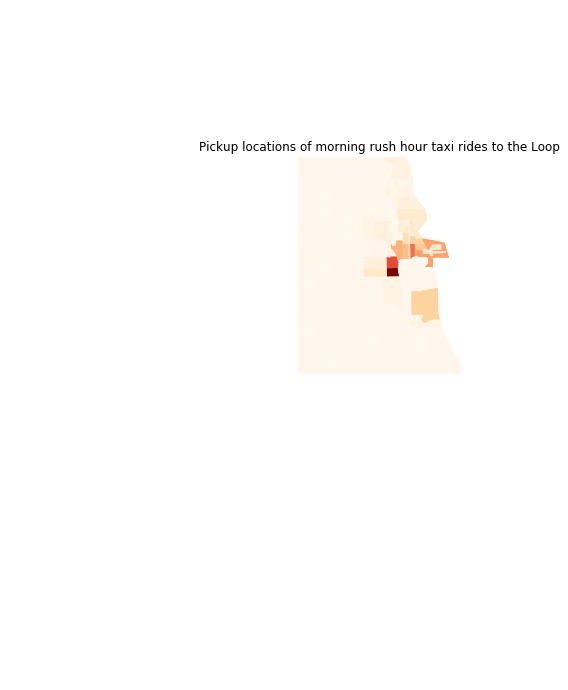

In [166]:
chi_map['am_to_loop_pickup'] = am_to_loop_pickup_count

chi_map.plot(column='am_to_loop_pickup', cmap='OrRd')
plt.axis('off')
plt.xlim(-9765000, -9750000)
plt.ylim(5105000, 5125000)
plt.title('Pickup locations of morning rush hour taxi rides to the Loop')
plt.savefig('Figs/am_to_loop_pickup.png')
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


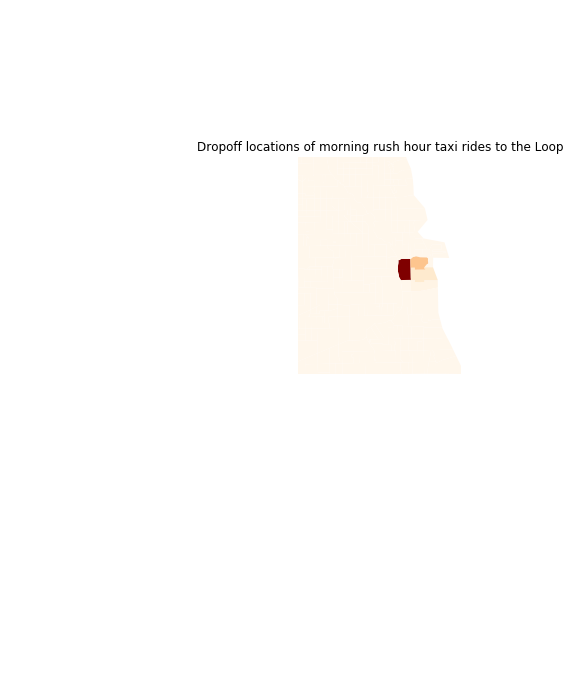

In [167]:
chi_map['am_to_loop_dropoff'] = am_to_loop_dropoff_count

chi_map.plot(column='am_to_loop_dropoff', cmap='OrRd')
plt.axis('off')
plt.xlim(-9765000, -9750000)
plt.ylim(5105000, 5125000)
plt.title('Dropoff locations of morning rush hour taxi rides to the Loop')
plt.savefig('Figs/am_to_loop_dropoff.png')
plt.show()

Do the same for evening peak data, and make plots of trips from the Loop.

In [120]:
#import the evening taxi rides to and from the loop
df_pm_from_loop = pd.read_json('Data/pm_from_loop.json')
df_pm_to_loop = pd.read_json('Data/pm_to_loop.json')

In [121]:
#distinguish weekdays and weekends (I could also do holidays if that's something I need to consider)
df_pm_from_loop['weekday'] = df_pm_from_loop['start_time'].apply(lambda x: int(date.weekday(x) < 5))
df_pm_to_loop['weekday'] = df_pm_to_loop['start_time'].apply(lambda x: int(date.weekday(x) < 5))

In [122]:
pm_from_loop_pickup_count = df_pm_from_loop[df_pm_from_loop.weekday == 1].groupby('Pickup Census Tract').count()['weekday']
pm_from_loop_dropoff_count = df_pm_from_loop[df_pm_from_loop.weekday == 1].groupby('Dropoff Census Tract').count()['weekday']
pm_to_loop_pickup_count = df_pm_to_loop[df_pm_to_loop.weekday == 1].groupby('Pickup Census Tract').count()['weekday']
pm_to_loop_dropoff_count = df_pm_to_loop[df_pm_to_loop.weekday == 1].groupby('Dropoff Census Tract').count()['weekday']

In [123]:
pm_to_loop_dropoff_count

Dropoff Census Tract
17031320100    1149124
17031320400     413705
17031320600     256078
17031839000     130979
17031839100    1673280
Name: weekday, dtype: int64

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


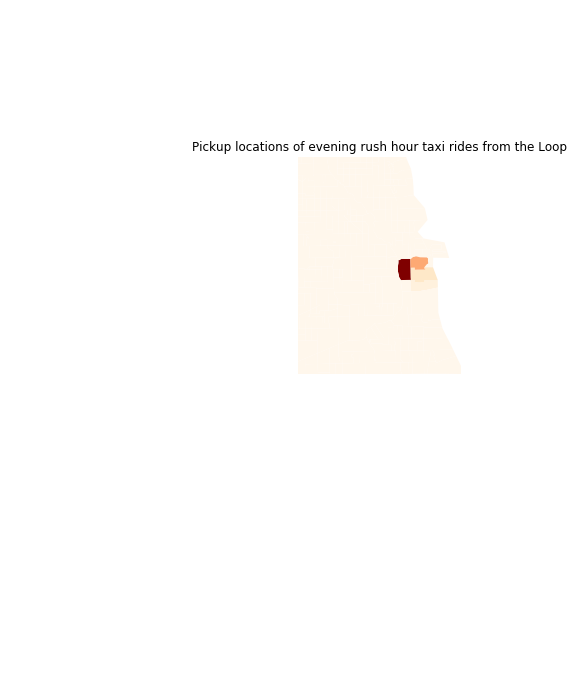

In [168]:
chi_map['pm_from_loop_pickup'] = pm_from_loop_pickup_count

chi_map.plot(column='pm_from_loop_pickup', cmap='OrRd')
plt.axis('off')
plt.xlim(-9765000, -9750000)
plt.ylim(5105000, 5125000)
plt.title('Pickup locations of evening rush hour taxi rides from the Loop')
plt.savefig('Figs/pm_from_loop_pickup.png')
plt.show()

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/colors.py:489: RuntimeWarning: invalid value encountered in less
  np.copyto(xa, -1, where=xa < 0.0)


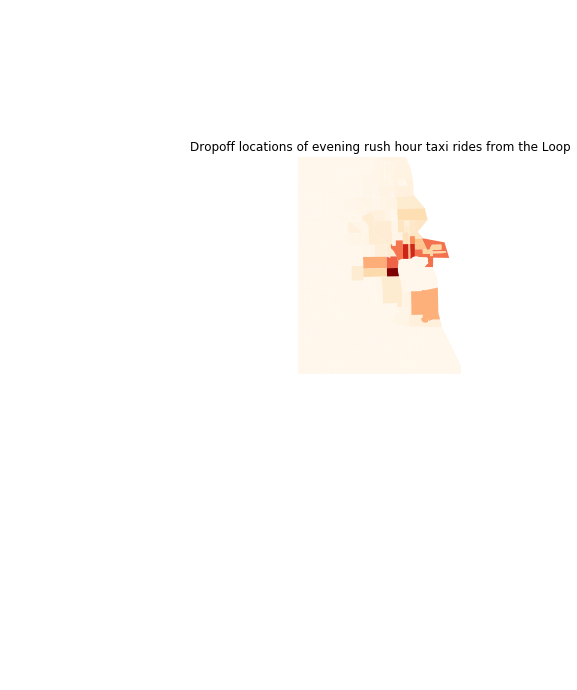

In [169]:
chi_map['pm_from_loop_dropoff'] = pm_from_loop_dropoff_count

chi_map.plot(column='pm_from_loop_dropoff', cmap='OrRd')
plt.axis('off')
plt.xlim(-9765000, -9750000)
plt.ylim(5105000, 5125000)
plt.title('Dropoff locations of evening rush hour taxi rides from the Loop')
plt.savefig('Figs/pm_from_loop_dropoff.png')
plt.show()

In [46]:
geopandas.GeoDataFrame?

In [ ]:
df_evening_from_loop = pd.read_json('evening_from_loop.json')
df_evening_to_loop = pd.read_json('evening_to_loop.json')

In [12]:
#Also parse timestamps
df['Trip Start Timestamp'] = df['Trip Start Timestamp'].apply(time_parser)

In [14]:
df.memory_usage(deep=True)

Index                     55892056
Trip Start Timestamp      55892056
Pickup Community Area     55892056
Dropoff Community Area    55892056
Fare                      55892056
hour                      55892056
dtype: int64

In [16]:
#Where do taxis go from the Loop? Where do they come to the Loop from?
from_Loop = df[df['Pickup Community Area'] == 32]['Dropoff Community Area'].value_counts()
to_Loop = df[df['Dropoff Community Area'] == 32]['Pickup Community Area'].value_counts()

In [18]:
#top 10
print(from_Loop.head(10))
print(to_Loop.head(10))

8.0     1769137
32.0    1074360
28.0     848461
7.0      210698
33.0     172997
76.0     172764
6.0      155506
24.0     150630
56.0      59875
22.0      35206
Name: Dropoff Community Area, dtype: int64
8.0     1149393
32.0    1074360
28.0     314592
76.0     165755
33.0     155862
7.0       60349
6.0       52331
56.0      47953
24.0      29117
41.0      20079
Name: Pickup Community Area, dtype: int64


As in the partial dataset, Near North Side, the Loop, Near West Side are the top 3 on both rankings. For almost every community area, the net flow is away from the Loop, which is not surprising.

In [27]:
(from_Loop - to_Loop).sort_values(ascending=False)

8.0     619744
28.0    533869
7.0     150349
24.0    121513
6.0     103175
22.0     30051
3.0      21241
33.0     17135
5.0      16008
77.0     14799
34.0     12472
35.0     12045
31.0     11954
56.0     11922
4.0       8441
60.0      7897
76.0      7009
16.0      5409
39.0      5290
21.0      5227
1.0       4755
2.0       3823
38.0      2669
14.0      2366
29.0      2038
23.0      1949
43.0      1696
27.0      1621
15.0      1539
42.0      1436
         ...  
68.0       358
64.0       346
20.0       314
71.0       292
67.0       254
66.0       247
37.0       236
17.0       229
49.0       203
72.0       185
48.0       174
45.0       173
53.0       149
9.0        141
57.0       126
63.0       123
73.0       121
65.0       102
75.0        95
51.0        89
18.0        50
62.0        33
52.0        29
50.0        28
55.0        21
74.0        18
47.0        17
54.0         7
32.0         0
41.0     -3900
Length: 77, dtype: int64

The only community area with net flow into the Loop is area 41, which is Hyde Park, an affluent enclave in the South Side that includes the University of Chicago.

In [28]:
#make maps
chi_map = geopandas.read_file('Data/Boundaries - Community Areas (current).geojson')
#Make area_num_1 int and thne the index, as that's all I use to id them
chi_map['area_num_1'] = chi_map['area_num_1'].astype(int)
chi_map = chi_map.set_index(chi_map.area_num_1)

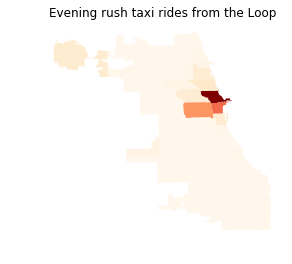

In [372]:
chi_map['From_Loop'] = from_Loop

chi_map.plot(column='From_Loop', cmap='OrRd')
plt.axis('off')
plt.title('Evening rush taxi rides from the Loop')
plt.savefig('Figs/evening_taxi_from_Loop_full.png')
plt.show()

In [367]:
plt.axes?

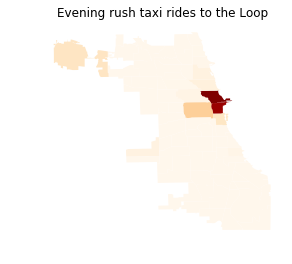

In [371]:
chi_map['To_Loop'] = to_Loop

chi_map.plot(column='To_Loop', cmap='OrRd')
plt.axis('off')
plt.title('Evening rush taxi rides to the Loop')
plt.savefig('Figs/evening_taxi_to_Loop_full.png')
plt.show()

## Fare

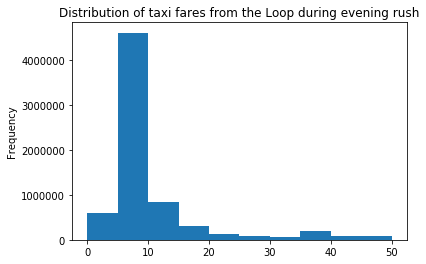

In [34]:
df['Fare'][df.Fare <= 50].plot.hist() #There are some outliers with very high fares

plt.title('Distribution of taxi fares from the Loop during evening rush')
plt.savefig('Figs/taxi_fare_hist_full.png')
plt.show()

## Prediction
It would be good to know, both for road users and the city, when congestion should be expected. First, make a very simple prediction model just based on simple date information. The taxi ride volume is declining because of Uber/Lyft over time, so use the number of days from the start as a feature. Traffic patterns change significantly by day of the week. I'll also include month as an additional feature, although this may end up not being very useful.

Later, add things like holiday and weather information. Chicago Data Portal also has event permit data. https://data.cityofchicago.org/Events/Chicago-Park-District-Event-Permits/pk66-w54g

In [47]:
#Make date column to group data by
df['date'] = df['Trip Start Timestamp'].apply(lambda x: x.date())

In [232]:
#Trips by date
df_counts = df['date'].value_counts().reset_index()

In [233]:
#the labels are not quite right
df_counts.head()

,index,date
0,2015-03-06,7173
1,2014-12-18,7135
2,2014-12-17,7038
3,2015-03-05,7015
4,2015-02-19,6993


In [240]:
df_by_date = pd.DataFrame()
df_by_date['date'] = df_counts['index']
df_by_date['trips'] = df_counts['date']

In [241]:
#Make features
df_by_date['day_from_start'] = df_by_date['date'].apply(lambda x: (x-date(2013,1,1)).days)
df_by_date['dayofweek'] = df_by_date['date'].apply(lambda x: x.weekday())
df_by_date['month'] = df_by_date['date'].apply(lambda x: x.month)

In [242]:
df_by_date

,date,trips,day_from_start,dayofweek,month
0,2015-03-06,7173,794,4,3
1,2014-12-18,7135,716,3,12
2,2014-12-17,7038,715,2,12
3,2015-03-05,7015,793,3,3
4,2015-02-19,6993,779,3,2
5,2014-05-15,6947,499,3,5
6,2014-12-19,6902,717,4,12
7,2014-08-01,6842,577,4,8
8,2014-04-03,6822,457,3,4
9,2014-12-11,6800,709,3,12


In [362]:
#day_from_start, dayofweek, and month are the features, to predict number of trips
X = df_by_date.loc[:,['day_from_start','dayofweek','month']].values
y = df_by_date.loc[:,['trips']].values.reshape((-1,1))

In [363]:
#dayofweek and month are categorical features
enc = preprocessing.OneHotEncoder()

In [364]:
#make one hot encoding for these 2 columns, and concatenate with day_from_start column
enc.fit(X[:,1:])
X_one_hot = np.concatenate((X[:,0].reshape((-1,1)),
                            enc.transform(X[:,1:]).toarray()), axis=1)

In [365]:
regr = linear_model.LinearRegression()
regr.fit(X_one_hot, y)
print(regr.score(X_one_hot, y))
print(regr.coef_)

0.619966464668
[[ -4.92379102e-01   1.48208817e+02   6.82888109e+02   8.17025516e+02
    8.79314400e+02   7.56058662e+02  -1.19208212e+03  -2.09141339e+03
   -6.30777256e+02  -9.82245498e+01   1.86807572e+02   1.23691763e+02
    7.10619503e-01   3.19250327e+01  -2.22557267e+02   1.00214817e+02
   -4.92315594e+01   3.39742354e+02   1.03120140e+02   1.14578333e+02]]


This is a super simple fit. There's a pretty significant downward slope over time, and weekends are of course not busy.

See which days don't fit well.

In [283]:
y_pred = regr.predict(X_one_hot)

In [284]:
df_by_date['prediction'] = y_pred
df_by_date['error'] = df_by_date['prediction'] - df_by_date['trips']

In [338]:
#What proportion of days do I predict correctly to 1000 trips? (OK but not that great)
len(df_by_date[df_by_date['error'] < 1000]) / len(df_by_date)

0.8918111177525403

In [306]:
#Look at the worst predicted days
df_by_date.sort_values('error')

,date,trips,day_from_start,dayofweek,month,prediction,error
148,2015-01-26,5934,755,0,1,3744.395345,-2189.604655
20,2014-11-17,6583,685,0,11,4512.759279,-2070.240721
42,2015-01-30,6375,759,4,1,4350.275674,-2024.724326
0,2015-03-06,7173,794,4,3,5150.627233,-2022.372767
4,2015-02-19,6993,779,3,2,4996.236535,-1996.763465
892,2014-08-03,4300,579,6,8,2322.423936,-1977.576064
1053,2015-07-05,3805,915,6,7,1834.212473,-1970.787527
55,2015-01-23,6263,752,4,1,4353.722328,-1909.277672
1,2014-12-18,7135,716,3,12,5240.059302,-1894.940698
753,2015-07-04,4621,914,5,7,2734.036122,-1886.963878


Worst overpredictions are considerably worse (by ~3000 trips and even greater) than the worst underpredictions (~2000 trips), and they are almost all holidays (Christmas, New Year's Day, Thanksgiving, etc.). The next thing to include in this model is holidays

Let's first see what happens if I just bluntly use US Federal Holidays as one categorical feature. This takes account of all the days that appear to be weekdays but are actually holidays.

In [321]:
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=date(2013,1,1), end=date(2017,12,31))

df_by_date['holidays'] = df_by_date['date'].apply(lambda x: int(x in holidays))

In [328]:
X_one_hot_2 = np.concatenate((X_one_hot, df_by_date['holidays'].values.reshape((-1,1))), axis=1)

In [343]:
#Run 2nd regression
regr2 = linear_model.LinearRegression()
regr2.fit(X_one_hot_2, y)
print(regr2.score(X_one_hot_2, y))
print(regr2.coef_)

0.688985881617
[[ -4.93130770e-01   3.58309106e+02   6.47823480e+02   7.81955835e+02
    8.85025312e+02   7.41033927e+02  -1.25741207e+03  -2.15673559e+03
   -5.39065693e+02  -8.01438224e+01   1.20472435e+02   5.78612135e+01
    1.26453633e+01  -3.57660200e+01  -2.10447349e+02   3.34432710e+01
   -3.68237247e+01   3.52396607e+02   1.99880045e+02   1.25547674e+02
   -2.43500439e+03]]


In [333]:
y_pred_2 = regr2.predict(X_one_hot_2)

In [334]:
df_by_date['prediction_2'] = y_pred_2
df_by_date['error_2'] = df_by_date['prediction_2'] - df_by_date['trips']

In [339]:
#Look at the worst predicted days
df_by_date.sort_values('error_2')

,date,trips,day_from_start,dayofweek,month,prediction,error,holidays,prediction_2,error_2
252,2014-11-11,5700,679,1,11,5050.392845,-649.607155,1,2743.934565,-2956.065435
470,2015-11-11,5218,1044,2,11,5004.811880,-213.188120,1,2698.074189,-2519.925811
677,2015-07-03,4790,913,4,7,4682.669281,-107.330719,1,2311.425017,-2478.574983
667,2014-10-13,4808,650,0,10,4766.614761,-41.385239,1,2621.237545,-2186.762455
892,2014-08-03,4300,579,6,8,2322.423936,-1977.576064,0,2257.256179,-2042.743821
0,2015-03-06,7173,794,4,3,5150.627233,-2022.372767,0,5136.031749,-2036.968251
762,2013-11-11,4606,314,0,11,4695.431925,89.431925,1,2634.412922,-1971.587078
1053,2015-07-05,3805,915,6,7,1834.212473,-1970.787527,0,1847.673620,-1957.326380
4,2015-02-19,6993,779,3,2,4996.236535,-1996.763465,0,5086.803837,-1906.196163
42,2015-01-30,6375,759,4,1,4350.275674,-2024.724326,0,4493.753198,-1881.246802


This simply confirms that Veterans Day and Columbus Day are not popular holidays, and that there's a lot of people taking vacation around Thanksgiving and Christmas.

In [348]:
#df_by_date[df_by_date['month'] == 12].sort_values('error')

## Data cleaning?

In [2]:
#Omit 'Taxi ID' for now, as it uses a lot of memory.
columns = ['Trip Start Timestamp', 'Trip End Timestamp',
           'Pickup Community Area', 'Dropoff Community Area', 'Fare']
#Use time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

df_list = []

for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                           iterator=True, chunksize=1000000):
    df = chunk[chunk['Pickup Community Area'] == 32.][columns] #select trips leaving the Loop
    df['hour'] = df['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column
    df_list.append(df[(df.hour >= 16) & (df.hour <= 18)]) #only append evening rush hour trips
    
    #print the number of DataFrames appended so far, and length of the last one appended
    print(len(df_list), len(df_list[-1]))

1 50541
2 47066


/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


3 7433


KeyboardInterrupt: 

There's something weird happening here. What's causing some chunks to have almost no matches? 3rd chunk is the first one with a problem. Look at it.

In [4]:
#pick out the 3rd chunk
count = 0
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                        iterator=True, chunksize=1000000,
                        low_memory=False):
    if count == 3:
        df_test = chunk
        break

    count += 1

It appears that many rows at certain spots in data have NaN as the community area (and other) values.

In [5]:
df_test.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Community Areas
3000000,f96e03e5c87dc42c85bc63209355543fa9196629,05a41dad4407c4cb2f03db2b1bb91a6624068a1fa381a0...,06/18/2015 09:30:00 AM,06/18/2015 10:00:00 AM,1560.0,11.4,NaN,NaN,NaN,NaN,...,$35.82,Credit Card,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000001,f96e04c385d9421d6c75ddd034b88fb4ce41b45e,4dcbf823cafcd373eaa71d2041d5daca63ab8ef17164ef...,06/26/2016 06:00:00 PM,06/26/2016 06:00:00 PM,0.0,0.0,NaN,NaN,NaN,NaN,...,$13.40,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000002,f96e05373b4b30e4528a77b3585934214367fbfb,52adf033bb533b6bd92cb6b683766bbfe9f239be7cc40c...,10/04/2013 04:45:00 PM,10/04/2013 04:45:00 PM,0.0,0.0,NaN,NaN,NaN,NaN,...,$29.81,Credit Card,Taxi Affiliation Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000003,f96e0b2ec695ea21787a403ba46ab9a29b2799a7,5505f562eceb4f7a23e813fa614c5dc63ce7de5f35123e...,12/05/2014 08:00:00 PM,12/06/2014 12:00:00 AM,14760.0,1.1,NaN,NaN,NaN,NaN,...,$8.81,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3000004,f96e065744bb74d36c1e2f00db096936610ccbc0,d41ab2be597b82c3e6b0b0ecccf98883a84db0d9aed4f6...,12/19/2014 02:00:00 PM,12/19/2014 02:15:00 PM,420.0,0.8,NaN,NaN,NaN,NaN,...,$6.05,Cash,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


There may or may not be anything I can do here. There's quite a bit of data that I can use.

One lingering question, though, is why are some parts of the data like this, but not others? If there's a correlation to some feature of the data, that's going to mess with any conclusions you might draw.

## Not needed

For figuring out congestion times, I need the start and end timestamps, pickup and dropoff community areas.

For the fine location analysis, I'll use Pickup/Dropoff Community Area to filter, and use the Pickup/Dropoff Centroid Locations.

In [45]:
#Just keep what I need for the plots.
columns_times = ['Trip Start Timestamp', 'Pickup Community Area', 'Dropoff Community Area']

#Write time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

df_list = []

#Do small scale thing first
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                        iterator=True, chunksize=100,
                        low_memory=False):
    
    df = chunk[(chunk['Pickup Community Area'] == 32.) |
               (chunk['Dropoff Community Area'] == 32.)][columns_times] #select trips involving the Loop
    
    df['hour'] = df['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column
#    df_list.append(df[(df.hour >= 16) & (df.hour <= 18)]) #only append evening rush hour trips
    df_list.append(df)
    
    print(len(df_list), len(df_list[-1]))
    if len(df_list) == 10: break

1 44
2 35
3 43
4 38
5 33
6 41
7 30
8 24
9 38
10 26


In [47]:
test0 = df_list[0].groupby('hour').count()
test1 = df_list[1].groupby('hour').count()

In [55]:
#simple sum doesn't do well with NaN
test0 + test1

,Trip Start Timestamp,Pickup Community Area,Dropoff Community Area
hour,,,
0,NaN,NaN,NaN
5,NaN,NaN,NaN
7,2.0,2.0,2.0
8,NaN,NaN,NaN
9,NaN,NaN,NaN
10,3.0,3.0,3.0
11,NaN,NaN,NaN
12,8.0,8.0,8.0
13,4.0,4.0,4.0


In [56]:
#Use the add method with fill_value option
test0.add(test1, fill_value=0)

,Trip Start Timestamp,Pickup Community Area,Dropoff Community Area
hour,,,
0,1.0,1.0,1.0
5,1.0,1.0,1.0
7,2.0,2.0,2.0
8,3.0,3.0,3.0
9,4.0,4.0,4.0
10,3.0,3.0,3.0
11,6.0,6.0,6.0
12,8.0,8.0,8.0
13,4.0,4.0,4.0


In [61]:
#Just keep what I need for the plots.
columns_times = ['Trip Start Timestamp', 'Pickup Community Area', 'Dropoff Community Area']

#Write time parser
time_parser = lambda x: pd.datetime.strptime(x, '%m/%d/%Y %I:%M:%S %p')

counts_from_loop = 0
counts_to_loop = 0
chunk_count = 0

#Do small scale thing first
for chunk in pd.read_csv('Data/Taxi_Trips.csv',
                        iterator=True, chunksize=100000,
                        low_memory=False):
    
    #select trips from loop
    df_from_loop = chunk[(chunk['Pickup Community Area'] == 32.)][columns_times]
    #select trips from loop
    df_to_loop = chunk[(chunk['Dropoff Community Area'] == 32.)][columns_times]
    
    #pick hours
    df_from_loop['hour'] = df_from_loop['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column
    df_to_loop['hour'] = df_to_loop['Trip Start Timestamp'].apply(lambda x: time_parser(x).hour) #create hour column

    #I just need the counts from groupby 'hour'
    try:
        counts_from_loop = counts_from_loop.add(df_from_loop.groupby('hour').count(), fill_value=0)
        counts_to_loop = counts_to_loop.add(df_to_loop.groupby('hour').count(), fill_value=0)
    except AttributeError: #1st addition fails
        counts_from_loop = df_from_loop.groupby('hour').count()
        counts_to_loop = df_to_loop.groupby('hour').count()
    
    chunk_count += 1
    
    if chunk_count % 10 == 0: print(chunk_count, counts_from_loop.loc[4, 'Trip Start Timestamp'])

10 600
20 1151
30 1258.0
40 1260.0
50 1568.0
60 2009.0
70 2165.0
80 2165.0
90 2165.0
100 2165.0
110 2165.0
120 2166.0
130 2166.0
140 2166.0
150 2166.0
160 2166.0
170 2166.0
180 2166.0
190 2166.0
200 2166.0
210 2674.0
220 3229.0
230 3833.0
240 4429.0
250 5015.0
260 5579.0
270 6225.0
280 6887.0
290 7523.0
300 8174.0
310 8756.0
320 9347.0
330 9953.0
340 10617.0
350 11246.0
360 11839.0
370 12475.0
380 13040.0
390 13675.0
400 14265.0
410 14871.0
420 15529.0
430 16116.0
440 16661.0
450 17263.0
460 17844.0
470 18402.0
480 18943.0
490 19530.0
500 20102.0
510 20729.0
520 21365.0
530 21918.0
540 22516.0
550 23092.0
560 23710.0
570 24291.0
580 24876.0
590 25474.0
600 26042.0
610 26577.0
620 27162.0
630 27726.0
640 28304.0
650 28889.0
660 29486.0
670 30083.0
680 30637.0
690 31233.0
700 31829.0
710 32443.0
720 33024.0
730 33631.0
740 34201.0
750 34828.0
760 35447.0
770 36029.0
780 36602.0
790 37199.0
800 37787.0
810 38439.0
820 39021.0
830 39623.0
840 40175.0
850 40716.0
860 41284.0
870 41876.0
880

Look at these counts.

In [62]:
print(counts_from_loop)

      Trip Start Timestamp  Pickup Community Area  Dropoff Community Area
hour                                                                     
0                 406300.0               406300.0                395765.0
1                 247843.0               247843.0                241203.0
2                 133582.0               133582.0                129643.0
3                  79228.0                79228.0                 76835.0
4                  57125.0                57125.0                 55549.0
5                  81699.0                81699.0                 80020.0
6                 165848.0               165848.0                162762.0
7                 382243.0               382243.0                375860.0
8                 728700.0               728700.0                718277.0
9                 979954.0               979954.0                966444.0
10                994411.0               994411.0                979585.0
11               1141240.0            

In [63]:
print(counts_to_loop)

      Trip Start Timestamp  Pickup Community Area  Dropoff Community Area
hour                                                                     
0                 352007.0               350355.0                352007.0
1                 252413.0               251333.0                252413.0
2                 179297.0               178718.0                179297.0
3                 126722.0               126317.0                126722.0
4                  88111.0                87709.0                 88111.0
5                  76454.0                75761.0                 76454.0
6                 198310.0               196551.0                198310.0
7                 635796.0               632236.0                635796.0
8                1321718.0              1314514.0               1321718.0
9                1621134.0              1612076.0               1621134.0
10               1330749.0              1323453.0               1330749.0
11               1116624.0            

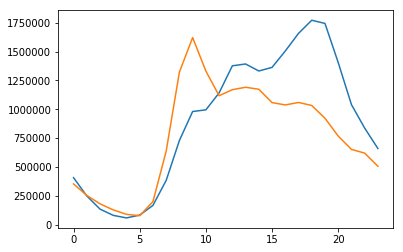

In [68]:
plt.plot(counts_from_loop['Trip Start Timestamp'])
plt.plot(counts_to_loop['Trip Start Timestamp'])

plt.show()